## Mecab 설치
-형태소 분석기

In [15]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 1.57 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-10-12 04:26:16--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 18.205.93.0, 18.205.93.1, 18.205.93.2, ...
Connecting to bitbucket.org (bitbucket.org)|18.205.93.0|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuserup

In [16]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [22]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/seunghak421/cp2-project/main/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7fbc06f5bb90>)

In [26]:
total_data = pd.read_table('ratings_total.txt', names=['평점', '리뷰'])
print('전체 리뷰 개수 :',len(total_data)) 

전체 리뷰 개수 : 200000


In [27]:
total_data[:5]

,평점,리뷰
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


## 훈련데이터,테스트 데이터 분리


In [39]:
total_data['label'] = np.select([total_data.평점 >=4], [1], default=0) #평점이 4점이상이면 레이블1, 이하면 레아블 0 부여해서 label열에 저장
total_data[:10]

,평점,리뷰,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...,0
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...,0
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요,0
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~,0
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...,0


In [33]:
total_data['평점'].nunique(), total_data['리뷰'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

중복 리뷰를 제외시키면 199908개 총 데이터는 20만개
중복 데이터 제거해줍니다

In [41]:
total_data.drop_duplicates(subset=['리뷰'], inplace=True) 

In [42]:
print('총 리뷰의 수 :',len(total_data))

총 리뷰의 수 : 199908


In [44]:
#결측치 확인
print(total_data.isnull().values.any())

False


훈련,테스트 데이터 3:1로 분리

In [61]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰 :', len(train_data))
print('테스트용 리뷰:', len(test_data))

훈련용 리뷰 : 149931
테스트용 리뷰: 49977


1,0으로 나는 레이블의 분포 확인

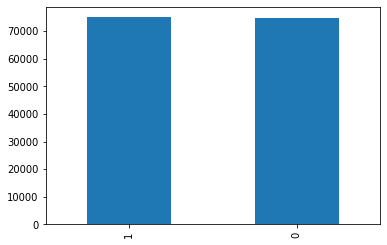

In [62]:
train_data['label'].value_counts().plot(kind = 'bar')

##데이터 정제
한글, 공백을 제외하고 모두 제거

In [65]:
train_data['리뷰'] = train_data['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #^을 붙여주지 않으면 리뷰 데이터가 대부분 다 날라감
train_data['리뷰'].replace('', np.nan, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [66]:
print(train_data.isnull().sum())

평점       0
리뷰       0
label    0
dtype: int64


In [70]:
print('전처리 후 훈련데이터 :',len(train_data))

전처리 후 훈련데이터 : 149931


In [67]:
test_data['리뷰'] = test_data['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 
test_data['리뷰'].replace('', np.nan, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [71]:
print('전처리 후 테스트데이터 :',len(test_data))

전처리 후 테스트데이터 : 49977


# 토큰화 